# Fine Tuning BERT for Disaster Tweets Classification

## Background and Motivation

Text classification is a technique used to categorize text into different groups. It has various applications: email providers use it to detect spam, marketing agencies analyze sentiment in customer reviews, and forum moderators identify inappropriate comments.

Traditionally, methods like tf-idf, word2vec, or bag-of-words (BOW) were used for feature generation in classification models. However, these methods sometimes struggle to capture word meanings in different contexts accurately. Recently, Bidirectional Encoder Representations from Transformers (BERT) have gained popularity for achieving better results in text classification due to their ability to encode word meanings more precisely.

BERT, trained on vast amounts of data from sources like BookCorpus and English Wikipedia, offers significant improvements in NLP tasks. Transfer learning, leveraging pre-trained models like BERT, allows quick fine-tuning for specific tasks with minimal training data, achieving state-of-the-art results.

Amazon SageMaker simplifies the machine learning process, providing tools to build, train, and deploy models efficiently. With SageMaker Python SDK, developers can train and deploy models using various frameworks.

## What is BERT?

BERT, introduced in 2018, is a transformative model for NLP tasks. It predicts masked words in sentences and learns text-pair representations for tasks like next sentence prediction. BERT's context-dependent word representations have revolutionized NLP.

## BERT Fine Tuning

A major challenge in NLP projects is the scarcity of labeled training data. Transfer learning addresses this by reusing pre-trained models. Fine-tuning BERT, trained on extensive data, with minimal training data yields state-of-the-art results in text classification and other NLP tasks.

## References

[1] [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)

[2] Yukun Zhu et al., "Aligning books and movies: Towards story-like visual explanations by watching movies and reading books," Proceedings of the IEEE International Conference on Computer Vision, 2015.

[3] [Getting Started with Google BERT](https://www.packtpub.com/product/getting-started-with-google-bert/9781838821593)

[4] [Data Science on AWS](https://www.oreilly.com/library/view/data-science-on/9781492079385/)


### Installing the dependencies

In [1]:
#!pip install transformers

In [2]:
import os
import numpy as np
import pandas as pd
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sagemaker.Session()    # Provides a collection of methods for working with SageMaker resources

bucket = "bert-sentiment-analysis-2"
prefix = "sagemaker/DEMO-pytorch-bert"

role = sagemaker.get_execution_role()      # Get the execution role for the notebook instance. 
                                           # This is the IAM role that we created for our notebook instance. 
                                           # We pass the role to the tuning job(later on).

### Prepare Train Data

In [4]:
from io import BytesIO
s3 = boto3.resource('s3')
bucket_name = bucket
file_name = 'input_data.csv'

obj = s3.Object(bucket_name, file_name)
data = obj.get()['Body'].read()
df_input = pd.read_csv(BytesIO(data),header=None,usecols=[1, 3],names=["label", "sentence"])

In [5]:
df_input = df_input.sample(frac=0.25, random_state=42)

# You can reset the index if you want to
df_input.reset_index(drop=True, inplace=True)

In [6]:
df_input.shape

(1903, 2)

In [7]:
sentences = df_input.sentence.values
labels = df_input.label.values

In [8]:
list(zip(sentences[80:85], labels[80:85]))

[('#tubestrike derailed you? Our #robertwelch cutlery offers will get you back on track http://t.co/bQ8Kyi7Gng http://t.co/GNZwxQktAm',
  0),
 ('Obliterated', 0),
 ('U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change',
  1),
 ('#breakingnews Rly tragedy in MP: Some live to recount horror: \x89ÛÏWhen I saw coaches of my train plunging into wa... http://t.co/eYOrBmF3O3',
  1),
 ('New Expansion Ideas - Bard Class Holy Trinity + 1 http://t.co/EGioxBabOe',
  0)]

### Cleaning Text
- As we can see from the above output, there are few information which are not that important, like URLs, Emojis, Tags, etc. So, now lets try to clean the dataset before we actually pass this data for training.

In [9]:
import string
import re

In [10]:
# Helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [11]:
df_input['sentence'] = df_input['sentence'].apply(lambda x: remove_URL(x))
df_input['sentence'] = df_input['sentence'].apply(lambda x: remove_emoji(x))
df_input['sentence'] = df_input['sentence'].apply(lambda x: remove_html(x))
df_input['sentence'] = df_input['sentence'].apply(lambda x: remove_punct(x))

df_input.head()

,label,sentence
0,1,So you have a new weapon that can cause unimag...
1,0,The fing things I do for GISHWHES Just got soa...
2,1,DT georgegalloway RT Galloway4Mayor ÛÏThe CoL...
3,0,Aftershock back to school kick off was great I...
4,0,in response to trauma Children of Addicts deve...


In [12]:
sentences = df_input.sentence.values
labels = df_input.label.values

### EDA

Let's spend couple of minutes to explore the dataset

a) Data Distribution

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

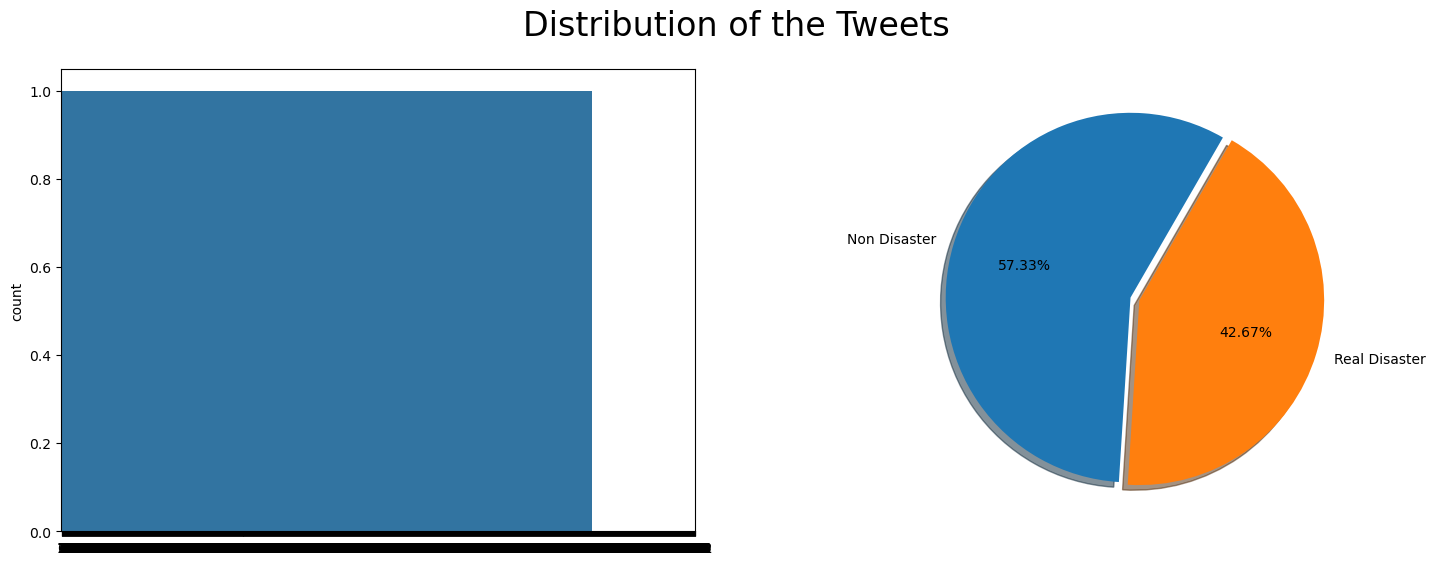

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df_input['label'], ax=axes[0])
axes[1].pie(df_input['label'].value_counts(),
            labels=['Non Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

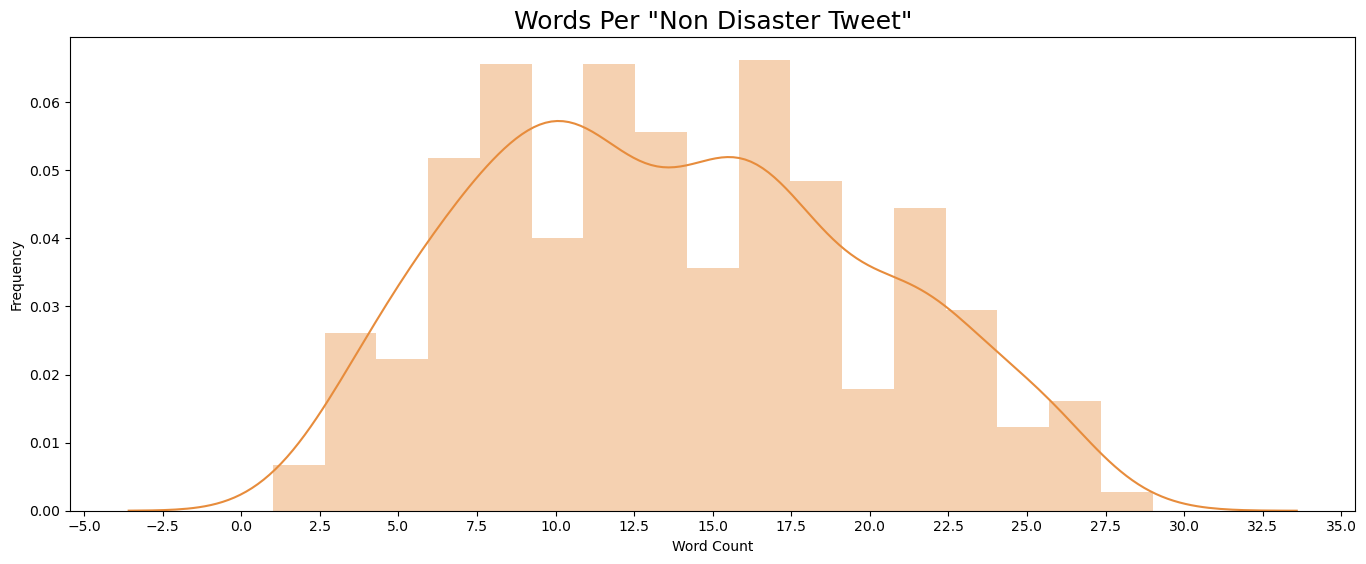

In [15]:
import utils
df_input['Word Count'] = df_input['sentence'].apply(lambda x: len(str(x).split()))
utils.plot_dist_char(df_input[df_input['label'] == 0], 'Word Count', 'Words Per "Non Disaster Tweet"')

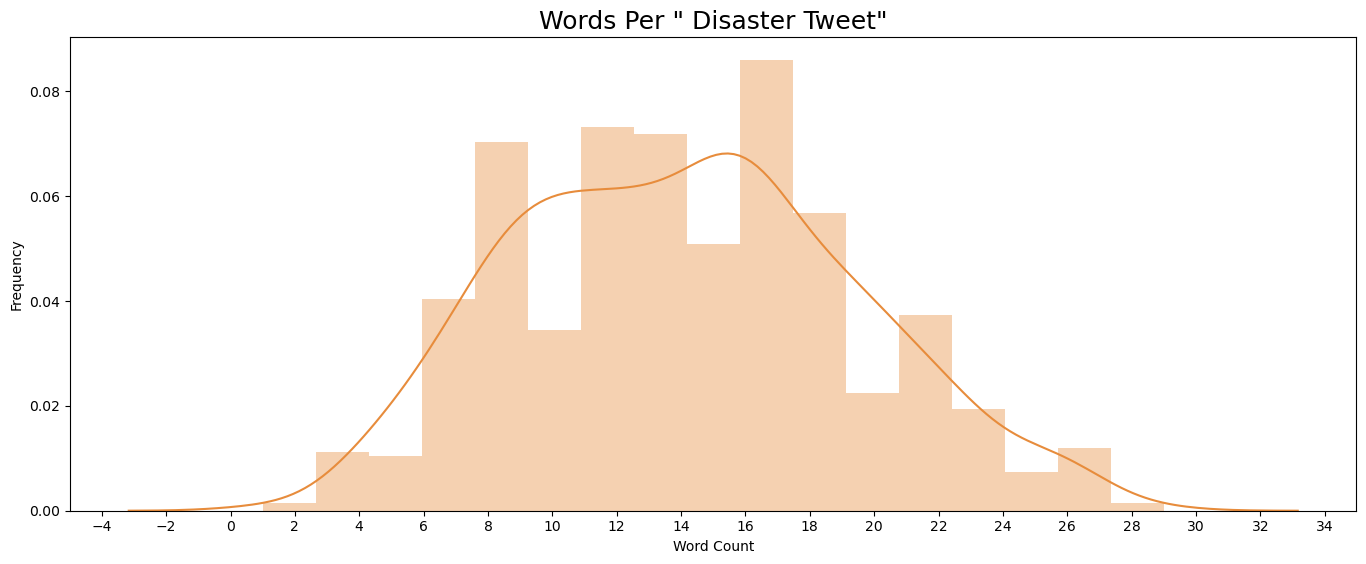

In [16]:
utils.plot_dist_char(df_input[df_input['label'] == 1], 'Word Count', 'Words Per " Disaster Tweet"')

## Split the dataset for training and testing
<b> We then split the dataset for training and testing.</b>

In [17]:
df_input.drop(['Word Count'], inplace = True, axis = 1)

In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_input, test_size = 0.2, stratify = df_input['label'])               # Default split ratio 75/25, we can modify using "test_size"

In [19]:
pd.concat([train['label'], train.drop(['label'], axis=1)], axis=1).to_csv("processed_data/train.csv", 
                                                                                  index=False, header=False)
pd.concat([test['label'], test.drop(['label'], axis=1)], axis=1).to_csv("processed_data/test.csv", 
                                                                                  index=False, header=False)

In [20]:
inputs_train = sagemaker_session.upload_data("processed_data/train.csv", bucket=bucket, key_prefix=prefix)
inputs_test = sagemaker_session.upload_data("processed_data/test.csv", bucket=bucket, key_prefix=prefix)

### Training script
We use the PyTorch-Transformers library, which contains PyTorch implementations and pre-trained model weights for many NLP models, including BERT.

Our training script should save model artifacts learned during training to a file path called model_dir, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in model_dir will be uploaded to S3 by SageMaker and will become available in S3 for deployment.

We save this script in a file named train_model.py, and put the file in a directory named code/. The full training script can be viewed under code/.

In [21]:
!pygmentize code/train_model.py

import subprocess

# Specify the library you want to install
library_to_install = "transformers==2.3.0"

# Install the library using pip
subprocess.call(["pip", "install", library_to_install])
import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.distributed as dist
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AdamW, BertForSequenceClassification, BertTokenizer

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MAX_LEN = 64  # this is the max length of the sentence

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    

        print("================ input sentences ===============")
        print(data)
        
        if isinstance(data, str):
            data = [data]
        elif isinstance(data, list) and len(data) > 0 and isinstance(data[0], str):
            pass
        else:
            raise ValueError("Unsupported input type. Input type can be a string or an non-empty list. \
                             I got {}".format(data))
                       
        #encoded = [tokenizer.encode(x, add_special_tokens=True) for x in data]
        #encoded = tokenizer(data, add_special_tokens=True) 
        
        # for backward compatibility use the following way to encode 
        # https://github.com/huggingface/transformers/issues/5580
        input_ids = [tokenizer.encode(x, add_special_tokens=True) for x in data]
        
        print("================ encoded sentences ==============")
        print(input_ids)

        # pad shorter sentence
        padded =  torch.zeros(len(input_ids), MA

### Train on Amazon SageMaker
We use Amazon SageMaker to train and deploy a model using our custom PyTorch code. The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see the SageMaker Python SDK documentation.

To start, we use the PyTorch estimator class to train our model. When creating our estimator, we make sure to specify a few things:

entry_point: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
source_dir: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
framework_version: the PyTorch version we want to use
The PyTorch estimator supports multi-machine, distributed PyTorch training. To use this, we just set train_instance_count to be greater than one. Our training script supports distributed training for only GPU instances.

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.



In [22]:
from sagemaker.pytorch import PyTorch

In [23]:
# 1. Defining the estimator 

estimator = PyTorch(entry_point="train_model.py",
                    source_dir="code",
                    role=role,
                    framework_version="1.5.0",
                    py_version="py3",
                    instance_count=2,
                    use_spot_instances=True,
                    max_wait=600,
                    max_run=600,
                    volume_size=30,
                    instance_type="ml.m4.2xlarge",             # Type of instance we want the training to happen
                    hyperparameters={"epochs": 1,
                                     "num_labels": 2,
                                     "backend": "gloo",        # gloo and tcp for cpu instances - gloo and nccl for gpu instances
                                    }
                   )

In [24]:
# 2. Start the Training 
estimator.fit({"training": inputs_train, "testing": inputs_test})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-03-06-10-50-19-686


2024-03-06 10:50:20 Starting - Starting the training job...
2024-03-06 10:50:36 Starting - Preparing the instances for training.........
2024-03-06 10:51:56 Downloading - Downloading input data...
2024-03-06 10:52:47 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-03-06 10:53:12,604 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-03-06 10:53:12,617 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,630 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-03-06 10:53:12,632 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-03-06 10:53:12,792 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,807 sagemaker-training-toolkit INFO   

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-03-06 10:53:12,237 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-03-06 10:53:12,254 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,267 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-03-06 10:53:12,270 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-03-06 10:53:12,455 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,469 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,484 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-06 10:53:12,497 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_paramete

End of defining BertForSequenceClassification
[2024-03-06 10:54:01.645 algo-1:27 INFO json_config.py:90] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2024-03-06 10:54:01.646 algo-1:27 INFO hook.py:192] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2024-03-06 10:54:01.646 algo-1:27 INFO hook.py:237] Saving to /opt/ml/output/tensors
[2024-03-06 10:54:01.646 algo-1:27 INFO state_store.py:67] The checkpoint config file /opt/ml/input/config/checkpointconfig.json does not exist.
[2024-03-06 10:54:01.650 algo-1:27 INFO hook.py:382] Monitoring the collections: losses
[2024-03-06 10:54:01.848 algo-1:27 WARNING hook.py:921] var is not Tensor or list or tuple of Tensors, module_name:module.bert.encoder.layer.0.attention.self NoneType
[2024-03-06 10:54:01.848 algo-1:27 WARNING hook.py:921] var is not Tensor or list or tuple of Tensors, module_name:module.bert.encoder.layer.0.attention.self NoneType
[2024-03-06 

[2024-03-06 10:54:08.790 algo-2:27 WARNING hook.py:921] var is not Tensor or list or tuple of Tensors, module_name:module.bert.encoder.layer.11 NoneType
[2024-03-06 10:54:08.790 algo-2:27 WARNING hook.py:921] var is not Tensor or list or tuple of Tensors, module_name:module.bert.encoder.layer.11 NoneType
[2024-03-06 10:54:08.790 algo-2:27 WARNING hook.py:921] var is not Tensor or list or tuple of Tensors, module_name:module.bert.encoder.layer.11 NoneType
Train Epoch: 1 [0/761 (0%)] Loss: 0.715056
Train Epoch: 1 [0/761 (0%)] Loss: 0.738611
Average training loss: 0.615781
Average training loss: 0.618820
Test set: Accuracy: 0.745407
Saving tuned model.
Test set: Accuracy: 0.748031
Saving tuned model.
/codebuild/output/src095943760/src/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
#011add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
#011add_(Tensor other, *, Number alpha)
INFO:__main__:Train Epoch: 1 [0

In [25]:
train.head()

,label,sentence
523,1,Severe Thunderstorms and Flash Flooding Possib...
991,1,FedEx no longer to transport bioterror germs i...
1867,0,PapiiChampoo What I enjoy most about the Obama...
1025,0,NathanFillion Hardly
1417,1,Reminder Mass murderer and white supremacist A...


In [26]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-south-1-915682971897/pytorch-training-2024-03-06-10-50-19-686/output/model.tar.gz), script artifact (s3://sagemaker-ap-south-1-915682971897/pytorch-training-2024-03-06-10-50-19-686/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-south-1-915682971897/pytorch-training-2024-03-06-10-57-37-044/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-training-2024-03-06-10-57-37-044
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2024-03-06-10-57-37-044
INFO:sagemaker:Creating endpoint with name pytorch-training-2024-03-06-10-57-37-044


-----!

In [27]:
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [38]:
predictor

In [28]:
class_label = {1: "Real disaster",
               0: "Not a disaster"}

In [29]:
test_sentences = ["I met my friend today by accident",
                  "Frank had a severe head injury after the car accident last month", 
                  "Just happened a terrible car crash"
                  ]

In [30]:
result = predictor.predict(test_sentences)
result = list(np.argmax(result, axis=1))

predicted_labels = [class_label[l] for l in result]

In [31]:
predicted_labels

['Not a disaster', 'Real disaster', 'Real disaster']

In [32]:
for tweet, label in zip(test_sentences, predicted_labels):
    print(f"{tweet} ---> {label}")

I met my friend today by accident ---> Not a disaster
Frank had a severe head injury after the car accident last month ---> Real disaster
Just happened a terrible car crash ---> Real disaster


In [33]:
sentence="I met my friend today by accident"

In [34]:
predictions = predictor.predict(sentence)
result = list(np.argmax(predictions, axis=1))
predicted_labels = [class_label[l] for l in result]
predicted_labels[0]

'Not a disaster'

In [35]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def hello_world():
    return 'Hello World!'

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [36]:
from flask import Flask

# Create a Flask application
app = Flask(__name__)

# Load your pre-trained model

# Define a route for making predictions
@app.route('/predict', methods=['POST'])
def predict():
    predictions = predictor.predict(sentence)
    result = list(np.argmax(predictions, axis=1))
    predicted_labels = [class_label[l] for l in result]
    return predicted_labels[0]


# Run the Flask application
if __name__ == '__main__':
    app.run(debug=True, host = "0.0.0.0",port=8000)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.16.70.111:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/ec2-user/anaconda3/envs

SystemExit: 1

In [ ]:
from flask import Flask, request, jsonify
app = Flask(__name__)

In [ ]:
import boto3

def call_sagemaker_endpoint(data):
    runtime = boto3.client('runtime.sagemaker')
    response = runtime.invoke_endpoint(EndpointName='pytorch-training-2024-03-05-13-14-58-106', ContentType='application/json', Body=data)
    return response['Body']

In [ ]:
@app.route('/predict', methods=['POST'])
def predict():
    predictions = predictor.predict(sentence)
    result = list(np.argmax(predictions, axis=1))
    predicted_labels = [class_label[l] for l in result]
    return predicted_labels[0]

In [ ]:
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)

In [ ]:
import requests

data = {'input_data': 'some data'}
response = requests.post('http://localhost:5000/predict', json=data)
print(response.json())